In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.cm as cm
import seaborn as sns
import sklearn

In [20]:
df=pd.read_csv("file_train_senza_outliers.csv", skipinitialspace=True )

In [21]:
genres = sorted(df['genre'].unique())
genres_mapping = dict(zip(genres, range(0, len(genres) + 1)))

In [40]:
df['genres_val'] = df['genre'].map(genres_mapping).astype(int)
df[['genre', 'genres_val']].head()

,genre,genres_val
0,j-dance,13
1,iranian,12
2,black-metal,1
3,bluegrass,2
4,happy,8


In [41]:
dk=df.drop(['name', 'explicit', 'artists','key', 'mode', 'album_name', 'genre', 'n_bars', 'n_beats'], axis=1)

In [42]:
dk=dk.drop(columns=df.columns[0], axis=1)

In [43]:
dk.head()

,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,processing,genres_val
0,241.76,0.69,0.51,-12.53,0.10,0.30,0.54,0.28,0.64,142.22,4.0,1.28,13
1,444.00,0.07,0.20,-24.80,0.08,0.28,0.93,0.36,0.03,75.60,4.0,2.37,12
2,333.51,0.36,0.85,-7.44,0.04,0.00,0.80,0.26,0.49,116.63,4.0,3.70,1
3,269.80,0.52,0.58,-5.61,0.08,0.07,0.00,0.12,0.38,140.88,4.0,1.28,2
4,307.65,0.64,0.69,-11.34,0.05,0.00,0.10,0.30,0.64,143.96,4.0,4.07,8


In [44]:
# min-max, fit and trasform directly
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(dk)

## KMeans

In [45]:
kmeans = KMeans(n_clusters=4, n_init=10, max_iter=100, random_state=94)# importanza di random state per ottenere gli stessi risultati
kmeans.fit(X_minmax)

KMeans(max_iter=100, n_clusters=4, random_state=94)

In [60]:
centersk = scaler.inverse_transform(kmeans.cluster_centers_)# stesso scaler anche per i k

In [50]:
dkk=dk.copy()
dkk['kmeans_labels'] = kmeans.labels_
dkk['kmeans_labels'] = dkk['kmeans_labels'].map({0:"A", 1:'B', 2:"C", 3:'D'})

In [53]:
print('Silhouette', silhouette_score(X_minmax, kmeans.labels_))

Silhouette 0.17239635697921948


In [54]:
silhouette_score(X_minmax, kmeans.labels_)

0.17239635697921948

In [99]:
sklearn.metrics.davies_bouldin_score(X_minmax, kmeans.labels_)

1.7338092176169564

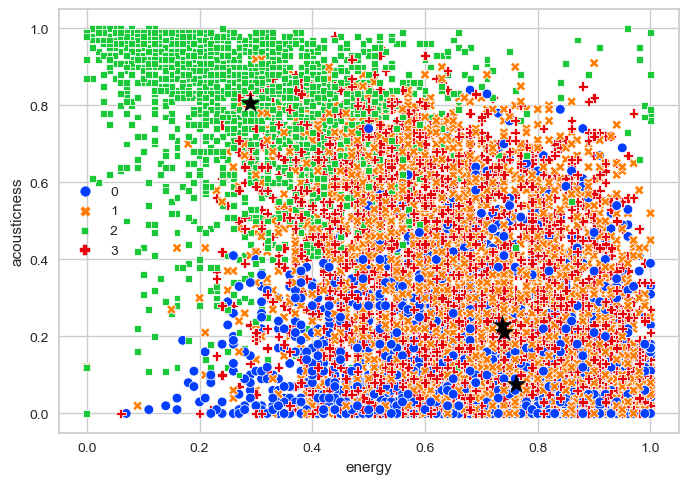

In [62]:
sns.scatterplot(data=dkk, y="acousticness", x="energy",  hue=kmeans.labels_, style=kmeans.labels_,
                palette="bright")
plt.legend()
plt.scatter(centersk[:,2], centersk[:,5], c='black', marker='*', s=200) #prendo le colonne e fisso i centroidi
plt.show()

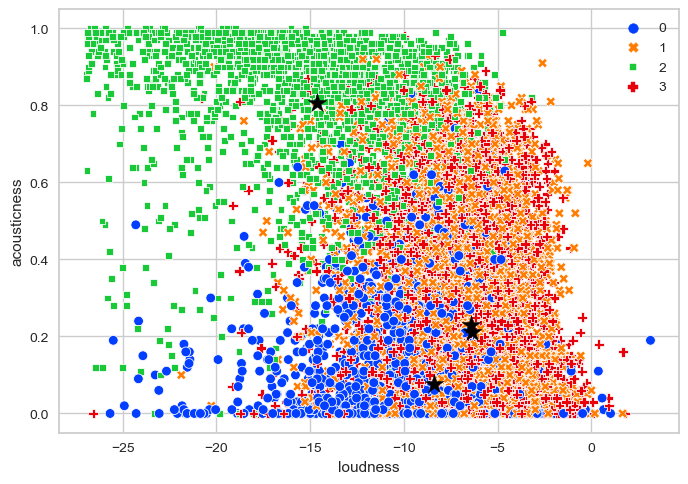

In [63]:
sns.scatterplot(data=dkk, x="loudness", y="acousticness",  hue=kmeans.labels_, style=kmeans.labels_,
                palette="bright")
plt.legend()
plt.scatter(centersk[:,3], centersk[:,5], c='black', marker='*', s=200) #prendo le colonne e fisso i centroidi
plt.show()

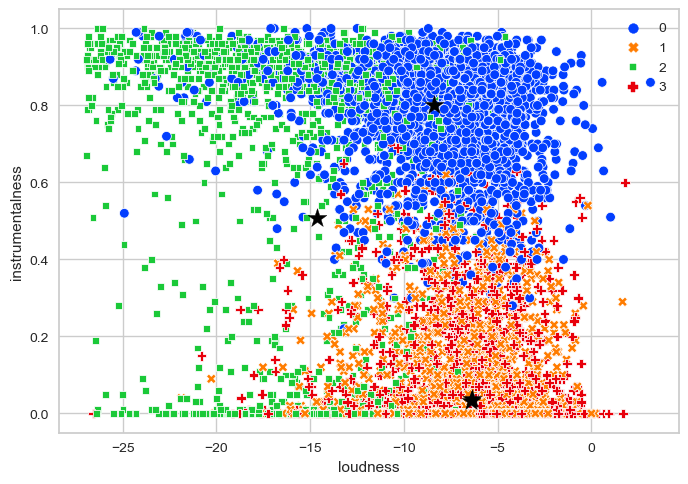

In [64]:
sns.scatterplot(data=dkk, x="loudness", y="instrumentalness",  hue=kmeans.labels_, style=kmeans.labels_,
                palette="bright")
plt.legend()
plt.scatter(centersk[:,3], centersk[:,6], c='black', marker='*', s=200) #prendo le colonne e fisso i centroidi
plt.show()

## DBScan

In [28]:
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan.fit(X_minmax)

DBSCAN(min_samples=10)

In [68]:
print('Silhouette', silhouette_score(X_minmax, dbscan.labels_))

Silhouette 0.12741745998622664


In [52]:
silhouette_score(X_minmax, dbscan.labels_)

0.12741745998622664

In [98]:
sklearn.metrics.davies_bouldin_score(X_minmax, dbscan.labels_)

2.8683895403629034

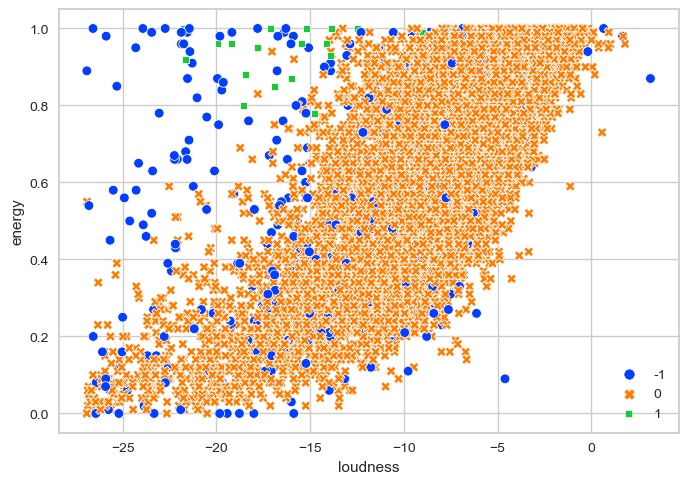

In [88]:
sns.scatterplot(data=dk, 
                x="loudness", 
                y="energy", 
                hue=dbscan.labels_, 
                style=dbscan.labels_, 
                palette="bright")
plt.show()

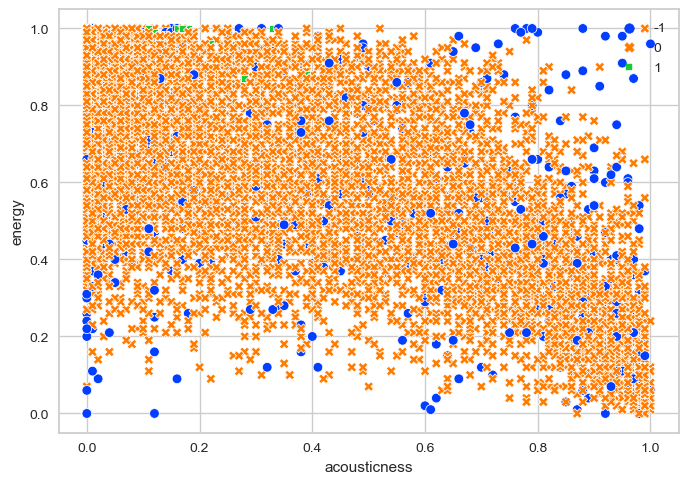

In [89]:
sns.scatterplot(data=dk, 
                x="acousticness", 
                y="energy", 
                hue=dbscan.labels_, 
                style=dbscan.labels_, 
                palette="bright")
plt.show()

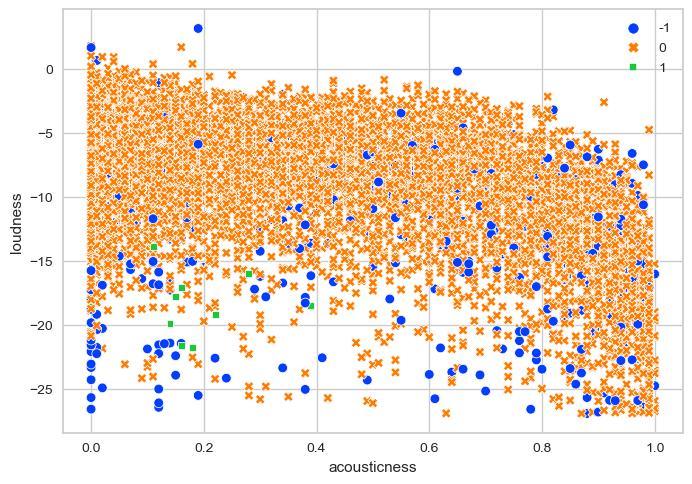

In [90]:
sns.scatterplot(data=dk, 
                y="loudness", 
                x="acousticness", 
                hue=dbscan.labels_, 
                style=dbscan.labels_, 
                palette="bright")
plt.show()

## Hierarchical

In [72]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [73]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model = model.fit(X_minmax)

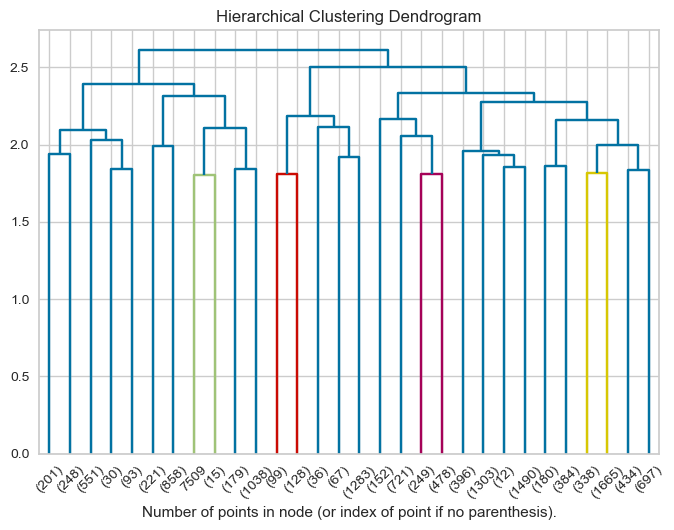

In [74]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [81]:
hier = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')
hier.fit(X_minmax)

AgglomerativeClustering(linkage='complete', n_clusters=5)

In [91]:
print('Silhouette', silhouette_score(X_minmax, hier.labels_))

Silhouette 0.1114948427611042


In [97]:
sklearn.metrics.davies_bouldin_score(X_minmax, hier.labels_)

2.140720157624443

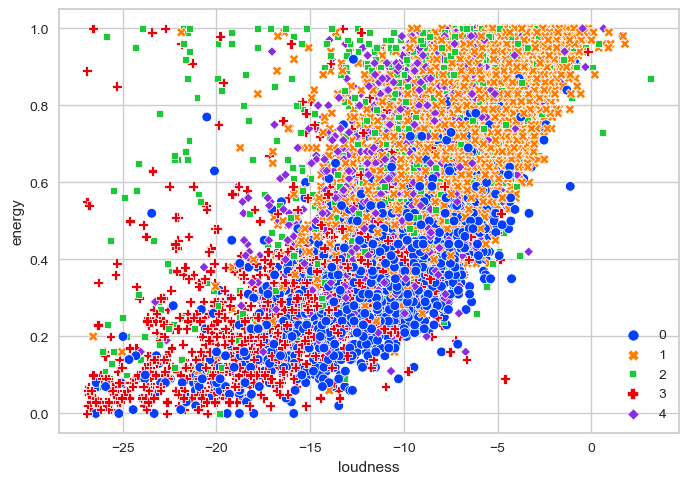

In [83]:
sns.scatterplot(data=dk, y="energy", x="loudness",  hue=hier.labels_, style=hier.labels_,
                palette="bright")
plt.show()

In [78]:
dist = squareform(pdist(X_minmax)) # using a precomputed distance matrix

In [80]:
hierdist = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage='complete')
hierdist.fit(dist)

AgglomerativeClustering(affinity='precomputed', linkage='complete',
                        n_clusters=5)

In [92]:
print('Silhouette', silhouette_score(X_minmax, hierdist.labels_))

Silhouette 0.1114948427611042


In [96]:
sklearn.metrics.davies_bouldin_score(X_minmax, hierdist.labels_)

2.140720157624443

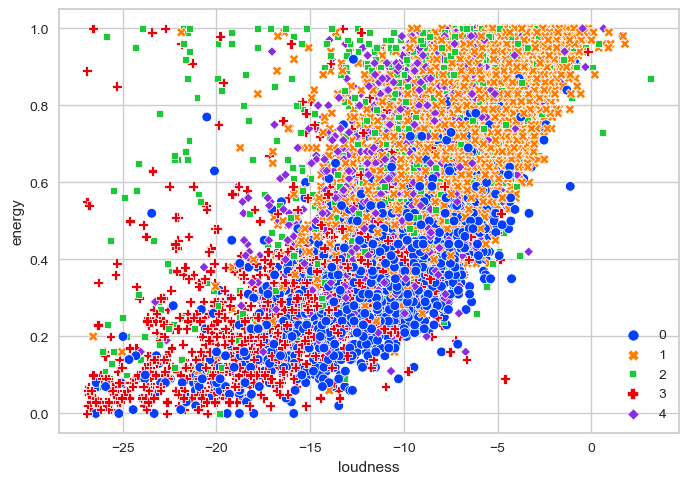

In [84]:
sns.scatterplot(data=dk, y="energy", x="loudness",  hue=hierdist.labels_, style=hierdist.labels_,
                palette="bright")
plt.show()

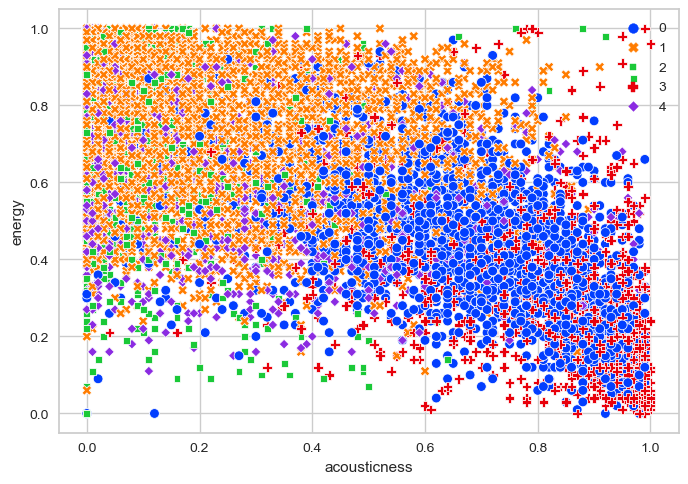

In [85]:
sns.scatterplot(data=dk, y="energy", x="acousticness",  hue=hierdist.labels_, style=hierdist.labels_,
                palette="bright")
plt.show()

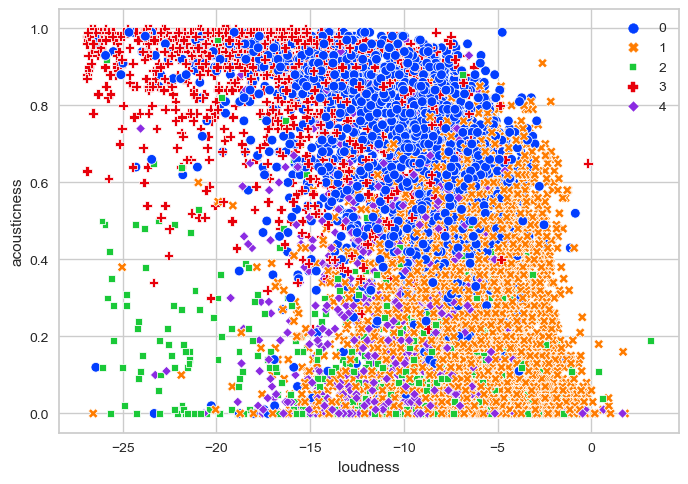

In [87]:
sns.scatterplot(data=dk, x="loudness", y="acousticness",  hue=hierdist.labels_, style=hierdist.labels_,
                palette="bright")
plt.show()